## Análisis exploratorio de datos.
### Análisis de datos del dataset de la competencia de Kaggle: " Petfinder Adoption Prediction"


In [12]:
# Importación de librerías

# Importación de Librerías
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
from wordcloud import WordCloud
import os
import re

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)


%matplotlib inline



In [13]:
#Importación de los datos.
dataset= pd.read_csv("../input/petfinder-adoption-prediction/train/train.csv")
print(f'El dataset está compuesto por {dataset.shape[0]} filas y {dataset.shape[1]} columnas.')
print(f'Los nombres de las columnas son:\n{", ".join(dataset.columns[:9])},')
print(f'{", ".join(dataset.columns[9: 18])},')
print(f'{", ".join(dataset.columns[18: ])} .')

El dataset está compuesto por 14993 filas y 24 columnas.
Los nombres de las columnas son:
Type, Name, Age, Breed1, Breed2, Gender, Color1, Color2, Color3,
MaturitySize, FurLength, Vaccinated, Dewormed, Sterilized, Health, Quantity, Fee, State,
RescuerID, VideoAmt, Description, PetID, PhotoAmt, AdoptionSpeed .


In [14]:
#Descripción del dataset
dataset.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type           14993 non-null  int64  
 1   Name           13728 non-null  object 
 2   Age            14993 non-null  int64  
 3   Breed1         14993 non-null  int64  
 4   Breed2         14993 non-null  int64  
 5   Gender         14993 non-null  int64  
 6   Color1         14993 non-null  int64  
 7   Color2         14993 non-null  int64  
 8   Color3         14993 non-null  int64  
 9   MaturitySize   14993 non-null  int64  
 10  FurLength      14993 non-null  int64  
 11  Vaccinated     14993 non-null  int64  
 12  Dewormed       14993 non-null  int64  
 13  Sterilized     14993 non-null  int64  
 14  Health         14993 non-null  int64  
 15  Quantity       14993 non-null  int64  
 16  Fee            14993 non-null  int64  
 17  State          14993 non-null  int64  
 18  Rescue

Text(0.5, 1.0, 'Cantidad de publicaciones por tipo de animal')

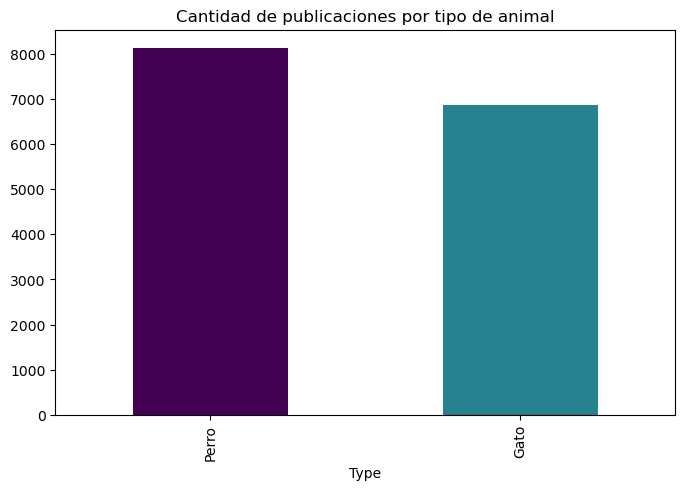

In [15]:
dataset.groupby('Type').size().plot(kind='bar', color=['#440154', '#26828e'], figsize=(8, 5))
plt.xticks(ticks=[0, 1], labels=['Perro', 'Gato'])
plt.title('Cantidad de publicaciones por tipo de animal')

Las mascotas que se encuentran en el dataset son perros y gatos. El objetivo es predecir la adopción de las mascotas.
En el próximo gráfico se puede observar la cantidad de adopciones por especie de mascota en cada una de las categorías de velocidad de adopción:



In [16]:

velocidad_de_adopcion= {0: 'Mismo día', 1:'1-7 días', 2: '30 días ', 3:  '30 -60 días ', 4: ' + de 90 días'}

In [17]:
velocidad_de_adopcion

{0: 'Mismo día',
 1: '1-7 días',
 2: '30 días ',
 3: '30 -60 días ',
 4: ' + de 90 días'}

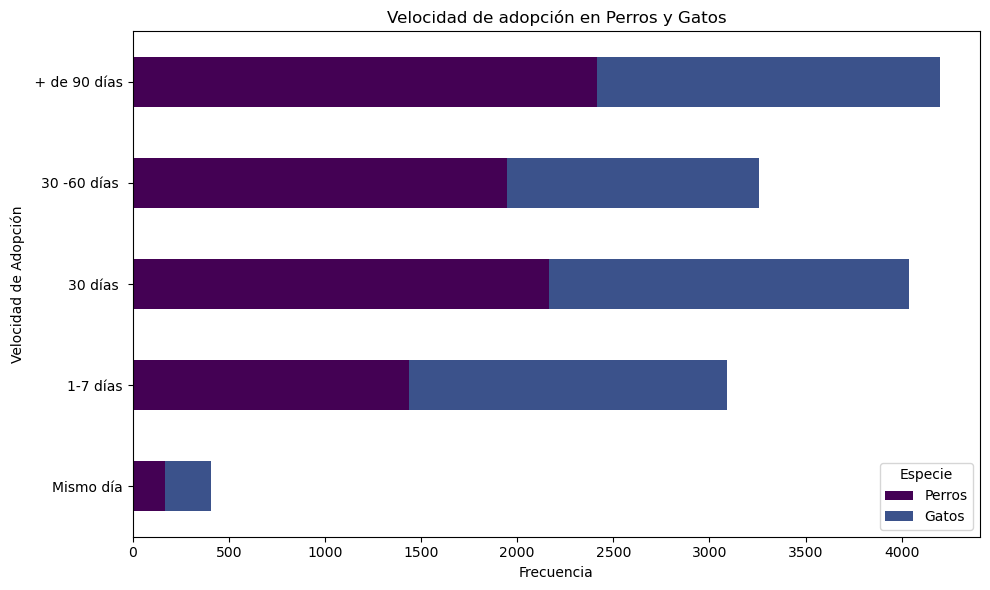

In [18]:
# Crear un DataFrame con las frecuencias de AdoptionSpeed para perros y gatos

dogs = dataset[dataset['Type'] == 1]
cats = dataset[dataset['Type'] == 2]

adoption_speed_counts = pd.DataFrame({
    'Perros': dogs['AdoptionSpeed'].value_counts().sort_index(),
    'Gatos': cats['AdoptionSpeed'].value_counts().sort_index()
})

# Crear el gráfico de barras apiladas con orientación horizontal
adoption_speed_counts.plot(
    kind='barh',
    stacked=True,
    color=[plt.cm.viridis(i / 4) for i in range(5)],
    figsize=(10, 6),
    title='Velocidad de adopción en Perros y Gatos'
)

plt.xlabel('Frecuencia')
plt.ylabel('Velocidad de Adopción')
plt.yticks(range(5), [velocidad_de_adopcion[i] for i in range(5)])
plt.legend(title='Especie')
plt.tight_layout()
plt.show()


Análisis de la columna de descripción de la mascota.

La columna Description tiene 13 valores nulos.
                 Description         Description_limpia      Removed_Special_Chars
0  Nibble is a 3+ month old   nibble is month old ball   ['I', "'", 'H', 'L', 'T',
1  I just found it alone yes  just found it alone yeste                 ['.', 'I']
2  Their pregnant mother was  their pregnant mother was  ['A', 'I', ',', 'H', 'T',
3  Good guard dog, very aler  good guard dog very alert            ['!', ',', 'G']


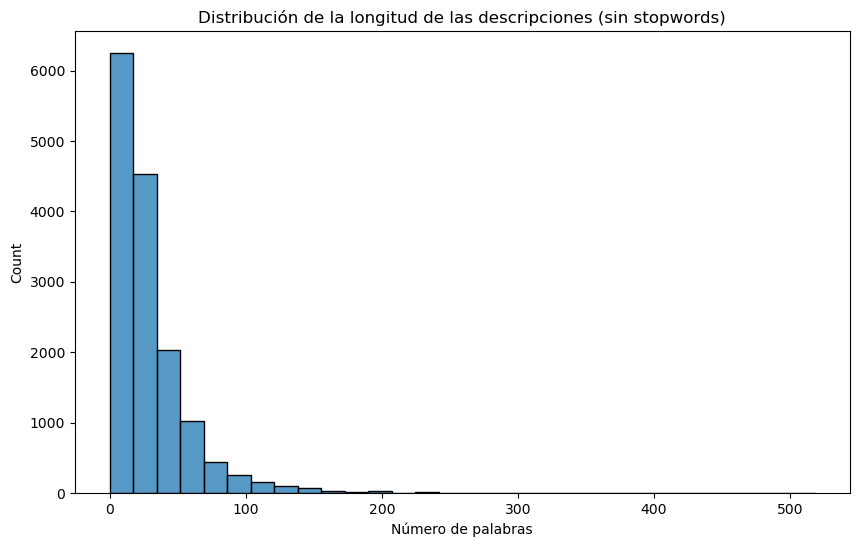

In [19]:

print( f'La columna Description tiene {dataset["Description"].isnull().sum()} valores nulos.')

#preprocesamiento de texto para la columna description


def clean_text(text):
    if pd.isna(text):
        return ''
    text = text.lower()  
    text = re.sub(r'\W+', ' ', text)  # Eliminar caracteres especiales
    text = re.sub(r'\b\w\b', ' ', text)  # Eliminar números o letras individuales
    text = re.sub(r'\s+', ' ', text).strip()  # Eliminar espacios extra
    return text

dataset['Description_limpia'] = dataset['Description'].apply(clean_text)

# Función para identificar caracteres especiales eliminados
def get_removed_special_chars(original, cleaned):
    if pd.isna(original):  # Si el texto original es NaN
        return []
    # Convertir ambos textos a conjuntos de caracteres
    original_chars = set(original)  # Conjunto de caracteres del texto original
    cleaned_chars = set(cleaned)    # Conjunto de caracteres del texto limpio
    # Identificar los caracteres que están en el original pero no en el limpio
    removed_chars = original_chars - cleaned_chars
    # Mostrar todo lo eliminado (caracteres especiales, números y letras individuales)
    all_removed_chars = [char for char in removed_chars if not char.isspace()]
    return all_removed_chars

# Aplicar la función para generar la nueva columna
dataset['Removed_Special_Chars'] = dataset.apply(
    lambda row: get_removed_special_chars(row['Description'], row['Description_limpia']), axis=1
)
# Crear un nuevo DataFrame con las columnas relevantes para el análisis de las descripciones

print(dataset[['Description', 'Description_limpia', 'Removed_Special_Chars']].head(4).applymap(lambda x: str(x)[:25]))

# Importar las stopwords en inglés desde sklearn
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Calcular la longitud de las descripciones limpias en términos de número de palabras
dataset['longitud_descripcion'] = dataset['Description_limpia'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

# Calcular la cantidad de palabras que no son stopwords en las descripciones limpias
dataset['cantidad_palabras_no_stopwords'] = dataset['Description_limpia'].apply(
    lambda x: len([word for word in x.split() if word.lower() not in ENGLISH_STOP_WORDS]) if isinstance(x, str) else 0
)

# Identificar las stopwords eliminadas de las descripciones limpias
dataset['stopwords_eliminadas'] = dataset['Description_limpia'].apply(
    lambda x: ([word for word in x.split() if word.lower() in ENGLISH_STOP_WORDS]) if isinstance(x, str) else 0
)

# Visualizar la distribución de la cantidad de palabras que no son stopwords
plt.figure(figsize=(10, 6))
sns.histplot(dataset['cantidad_palabras_no_stopwords'], bins=30)
plt.title('Distribución de la longitud de las descripciones (sin stopwords)')
plt.xlabel('Número de palabras')
plt.show()


In [20]:
print("Longitud máxima:", dataset['longitud_descripcion'].max())
print("Longitud mínima:", dataset['longitud_descripcion'].min())
print("Longitud promedio:", dataset['longitud_descripcion'].mean())
print("Longitud mediana:", dataset['longitud_descripcion'].median())
print("Longitud tercer cuartil:", dataset['longitud_descripcion'].quantile(0.75))


Longitud máxima: 1164
Longitud mínima: 0
Longitud promedio: 59.39998666044154
Longitud mediana: 42.0
Longitud tercer cuartil: 76.0


In [21]:
dataset['descripcion_para_analisis'] = dataset['Description_limpia'].apply(lambda x: ([word for word in x.split() if word.lower() not in ENGLISH_STOP_WORDS]) if isinstance(x, str) else 0)
dataset['palabras_caracteres_eliminados']= dataset['Removed_Special_Chars']+dataset['stopwords_eliminadas'] 


(dataset[['Description', 'palabras_caracteres_eliminados', 'descripcion_para_analisis']].head(4))

,Description,palabras_caracteres_eliminados,descripcion_para_analisis
0,Nibble is a 3+ month old ball of cuteness. He is energetic and playful. I rescued a couple of cats a few months ago but could not get them neutered in time as the clinic was fully scheduled. The result was this little kitty. I do not have enough space and funds to care for more cats in my household. Looking for responsible people to take over Nibble's care.,"[I, ', H, L, T, 3, +, ., N, is, of, he, is, and, of, few, but, could, not, get, them, in, as, the, was, the, was, this, do, not, have, enough, and, to, for, more, in, my, for, to, take, over]","[nibble, month, old, ball, cuteness, energetic, playful, rescued, couple, cats, months, ago, neutered, time, clinic, fully, scheduled, result, little, kitty, space, funds, care, cats, household, looking, responsible, people, nibble, care]"
1,I just found it alone yesterday near my apartment. It was shaking so I had to bring it home to provide temporary care.,"[., I, found, it, alone, my, it, was, so, had, to, it, to]","[just, yesterday, near, apartment, shaking, bring, home, provide, temporary, care]"
2,"Their pregnant mother was dumped by her irresponsible owner at the roadside near some shops in Subang Jaya. Gave birth to them at the roadside. They are all healthy and adorable puppies. Already dewormed, vaccinated and ready to go to a home. No tying or caging for long hours as guard dogs. However, it is acceptable to cage or tie for precautionary purposes. Interested to adopt pls call me.","[A, I, ,, H, T, N, S, G, ., J, their, was, by, her, at, the, some, in, to, them, at, the, they, are, all, and, already, and, to, go, to, no, or, for, as, however, it, is, to, or, for, to, call, me]","[pregnant, mother, dumped, irresponsible, owner, roadside, near, shops, subang, jaya, gave, birth, roadside, healthy, adorable, puppies, dewormed, vaccinated, ready, home, tying, caging, long, hours, guard, dogs, acceptable, cage, tie, precautionary, purposes, interested, adopt, pls]"
3,"Good guard dog, very alert, active, obedience waiting for her good master, plz call or sms for more details if you really get interested, thanks!!","[!, ,, G, very, for, her, call, or, for, more, if, you, get]","[good, guard, dog, alert, active, obedience, waiting, good, master, plz, sms, details, really, interested, thanks]"


[('home', 7849), ('dog', 4540), ('cat', 4093), ('adoption', 4025), ('good', 3563), ('adopt', 3343), ('old', 2881), ('contact', 2801), ('interested', 2784), ('looking', 2766), ('playful', 2749), ('love', 2689), ('loving', 2665), ('kitten', 2626), ('care', 2468), ('puppy', 2325), ('owner', 2275), ('healthy', 2260), ('cats', 2193), ('house', 2178)]


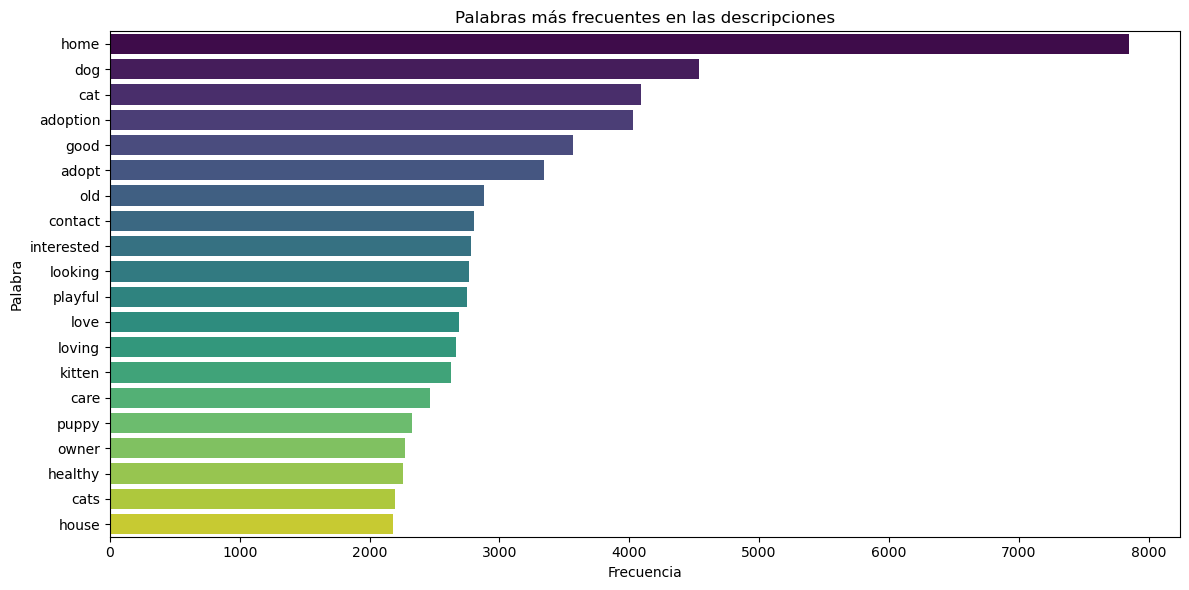

In [22]:
# Combinar todas las descripciones en una lista de palabras
import itertools
from collections import Counter 
# Combinar todas las palabras de la columna 'descripcion_para_analisis'
todas_palabras = list(itertools.chain.from_iterable(dataset['descripcion_para_analisis']))
palabras_comunes = Counter(todas_palabras).most_common(20)
print(palabras_comunes)



# Visualizar con un gráfico de barras
plt.figure(figsize=(12, 6))
palabras_df = pd.DataFrame(palabras_comunes, columns=['Palabra', 'Frecuencia'])
sns.barplot(x='Frecuencia', y='Palabra', data=palabras_df)
plt.title('Palabras más frecuentes en las descripciones')
paleta_colores = [plt.cm.viridis(i / len(palabras_comunes)) for i in range(len(palabras_comunes))]
sns.barplot(x='Frecuencia', y='Palabra', data=palabras_df, palette=paleta_colores)
plt.tight_layout()
plt.show();


In [23]:
palabras_comunes

[('home', 7849),
 ('dog', 4540),
 ('cat', 4093),
 ('adoption', 4025),
 ('good', 3563),
 ('adopt', 3343),
 ('old', 2881),
 ('contact', 2801),
 ('interested', 2784),
 ('looking', 2766),
 ('playful', 2749),
 ('love', 2689),
 ('loving', 2665),
 ('kitten', 2626),
 ('care', 2468),
 ('puppy', 2325),
 ('owner', 2275),
 ('healthy', 2260),
 ('cats', 2193),
 ('house', 2178)]

In [24]:
def contiene_palabra_comun(texto, palabras_comunes):
    if texto.contains.any(palabra for palabra, _ in palabras_comunes):
        return 1
    else:
        return 0

In [31]:
import pandas as pd
import numpy as np

# Definimos la función correctamente para verificar si una descripción contiene palabras comunes
def contiene_palabra_comun(texto, lista_palabras):
    # Verificamos que el texto sea un string válido
    if not isinstance(texto, str):
        return 0
    
    # Convertimos el texto a minúsculas
    texto = texto.lower()
    
    # Verificamos si lista_palabras es una lista de tuplas (palabra, valor)
    if isinstance(lista_palabras, list) and len(lista_palabras) > 0 and isinstance(lista_palabras[0], tuple):
        # Si es una lista de tuplas, extraemos solo las palabras
        for palabra, _ in lista_palabras:
            if palabra.lower() in texto:
                return 1
    else:
        # Si es una lista simple de palabras
        for palabra in lista_palabras:
            if str(palabra).lower() in texto:
                return 1
    
    return 0

# Aplicamos la función correctamente a cada elemento de la columna
dataset['contiene'] = dataset['Description_limpia'].apply(
    lambda x: contiene_palabra_comun(x, palabras_comunes)
)

# Mostramos las primeras filas para verificar
print(dataset.contiene.value_counts())

contiene
1    14021
0      972
Name: count, dtype: int64


<Axes: xlabel='AdoptionSpeed'>

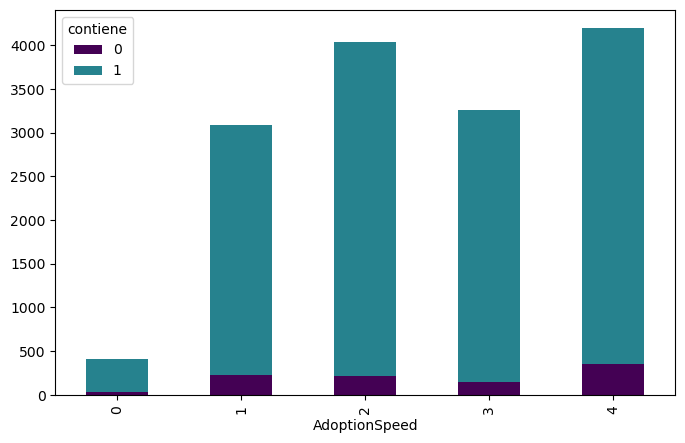

In [32]:
dataset.groupby('AdoptionSpeed')['contiene'].value_counts().unstack().plot(kind='bar', stacked=True, color=['#440154', '#26828e'], figsize=(8, 5))

In [ ]:
def contiene_palabra_comun(texto, lista_palabras):
    # Verificamos que el texto sea un string (para evitar errores con valores NaN)
    if isinstance(texto, str):
        # Convertimos el texto a minúsculas para hacer la comparación insensible a mayúsculas
        texto_lower = texto.lower()
        # Verificamos si alguna palabra de la lista está en el texto
        for palabra in lista_palabras:
            if palabra.lower() in texto_lower:
                return True
    return False

# Creamos la nueva columna 'contiene_palabra_comun'
dataset['contiene_palabra_comun'] = dataset['Descripcion_limpia'].apply(
    lambda x: contiene_palabra_comun(x, palabras_comunes)
)

# Mostramos las primeras filas del dataframe con la nueva columna
print(dataset[['Descripcion_limpia', 'contiene_palabra_comun']].head())

# Si quieres contar cuántas descripciones contienen palabras comunes
total_con_palabras_comunes = dataset['contiene_palabra_comun'].sum()
porcentaje = (total_con_palabras_comunes / len(dataset)) * 100

print(f"\nTotal de descripciones con palabras comunes: {total_con_palabras_comunes}")
print(f"Porcentaje del total: {porcentaje:.2f}%")

# Si quieres saber cuáles palabras comunes aparecen más frecuentemente
# Podemos crear una función más detallada
def palabras_encontradas(texto, lista_palabras):
    if not isinstance(texto, str):
        return []
    
    texto_lower = texto.lower()
    return [palabra for palabra in lista_palabras if palabra.lower() in texto_lower]

# Crear una columna con la lista de palabras comunes encontradas en cada descripción
dataset['palabras_comunes_encontradas'] = dataset['Descripcion_limpia'].apply(
    lambda x: palabras_encontradas(x, palabras_comunes)
)

# Contar la frecuencia de cada palabra común
contador_palabras = {}
for palabras in dataset['palabras_comunes_encontradas']:
    for palabra in palabras:
        if palabra in contador_palabras:
            contador_palabras[palabra] += 1
        else:
            contador_palabras[palabra] = 1

# Ordenar el contador por frecuencia, de mayor a menor
palabras_ordenadas = sorted(contador_palabras.items(), key=lambda x: x[1], reverse=True)

print("\nFrecuencia de cada palabra común:")
for palabra, conteo in palabras_ordenadas[:10]:  # Mostrar las 10 más frecuentes
    print(f"{palabra}: {conteo} veces")

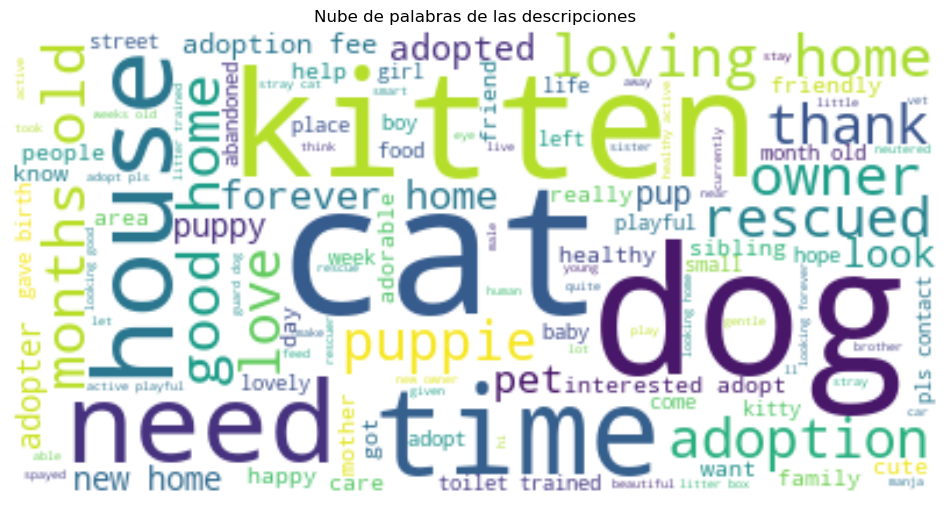

In [ ]:
from wordcloud import ImageColorGenerator

# Crear una nube de palabras a partir de las descripciones limpias
# Usar los colores del mapa de calor para la nube de palabras
cmap = plt.get_cmap('coolwarm')
wordcloud = WordCloud(background_color='white', colormap='viridis').generate(" ".join(todas_palabras))

# Visualizar la nube de palabras
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras de las descripciones')
plt.show()

Análisis de la columna nombre de las mascotas.

In [ ]:
import unicodedata
import re

# Función para limpiar texto y dejar solo caracteres alfanuméricos y espacios
def clean_text_unicode(text):
    if pd.isna(text):
        return ''
    # Normalizar texto y filtrar caracteres alfanuméricos
    text = ''.join(
        char for char in unicodedata.normalize('NFKD', text)
        if char.isalnum() or char.isspace()
    )
    # Eliminar caracteres específicos como 'ð' o patrones no deseados
    text = re.sub(r'[ð]', '', text)  # Eliminar 'ð'
    text = re.sub(r'ðð', '', text)  # Eliminar 'ðð'
    text = text.lower()  # Convertir a minúsculas
    text = re.sub(r'\s+', ' ', text).strip()  # Eliminar espacios extra
    return text

# Aplicar la función a la columna 'Name'
dataset['Nombres_limpios'] = dataset['Name'].apply(lambda x: clean_text_unicode(x))
# Calcular frecuencias y porcentajes
freq_percent = (
    dataset.groupby('Type')['Nombres_limpios']
    .value_counts(dropna=False)
    .rename('Frecuencia')
    .reset_index()
)

freq_percent['Porcentaje (%)'] = (
    freq_percent['Frecuencia'] /
    freq_percent.groupby('Type')['Frecuencia'].transform('sum') * 100
).round(2)

freq_percent

,Type,Nombres_limpios,Frecuencia,Porcentaje (%)
0,1,,659,8.10
1,1,lucky,50,0.61
2,1,puppy,49,0.60
3,1,brownie,45,0.55
4,1,max,36,0.44
...,...,...,...,...
9414,2,zoro luna,1,0.01
9415,2,zorro mira,1,0.01
9416,2,zuba,1,0.01
9417,2,æ aa1,1,0.01


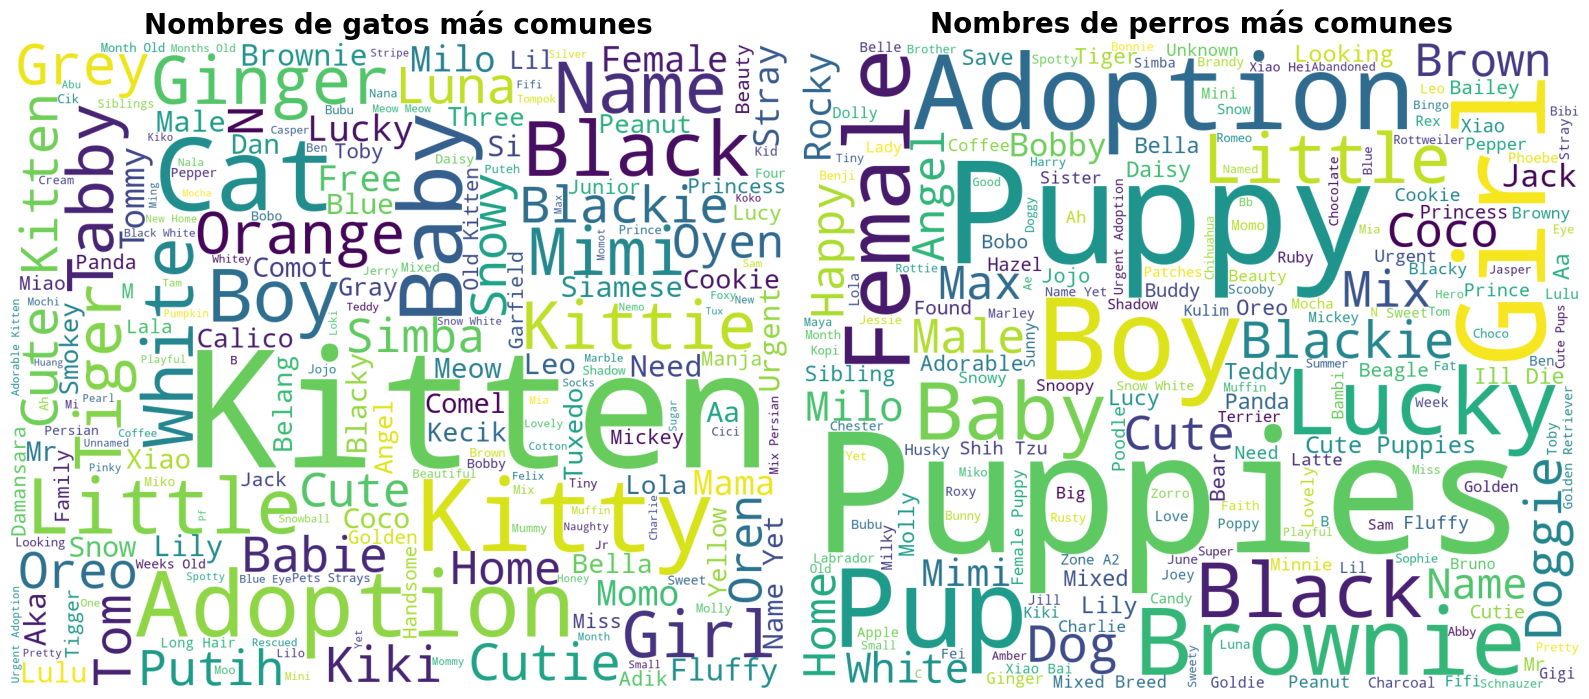

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

fig, axes = plt.subplots(1, 2, figsize=(16, 12))

# Wordcloud para gatos
text_cat = ' '.join(dataset.loc[dataset['Type'] == 2, 'Nombres_limpios'].fillna('').str.title().values)
wordcloud_cat = WordCloud(max_font_size=None, background_color='white',
                          width=1200, height=1000).generate(text_cat)

axes[0].imshow(wordcloud_cat)
axes[0].set_title('Nombres de gatos más comunes', fontsize=20, fontweight='bold')
axes[0].axis('off')  # Quita ejes
for spine in axes[0].spines.values():
    spine.set_visible(False)  # Quita marco

# Wordcloud para perros
text_dog = ' '.join(dataset.loc[dataset['Type'] == 1, 'Nombres_limpios'].fillna('').str.title().values)
wordcloud_dog = WordCloud(max_font_size=None, background_color='white',
                          width=1200, height=1000).generate(text_dog)

axes[1].imshow(wordcloud_dog)
axes[1].set_title('Nombres de perros más comunes', fontsize=20, fontweight='bold')
axes[1].axis('off')  # Quita ejes
for spine in axes[1].spines.values():
    spine.set_visible(False)  # Quita marco

plt.tight_layout()
plt.show()


In [ ]:
# Análisis de los tiempos de adopción de animales sin nombre
print(f' Hay {len(dataset[dataset["Nombres_limpios"] == ""])} registros con el campo de  nombre vacío en el dataset')
print(f'Hay {len(dataset[dataset["Nombres_limpios"].str.contains("no name|name", case=False, na=False)])} registros con "No Name" o similar en campo Name  del dataset')
# Valores similares a "No Name" en la columna "Name"
dataset[dataset["Nombres_limpios"].str.contains("no name|name", case=False, na=False)].Name.value_counts().head()

 Hay 1274 registros con el campo de  nombre vacío en el dataset
Hay 177 registros con "No Name" o similar en campo Name  del dataset


Name
No Name         54
No Name Yet     22
Nameless         6
Unnamed          5
No Names Yet     4
Name: count, dtype: int64

In [ ]:
# Completamos los campos vacíos de la columna Name con "Sin Nombre" y unificamos los valores similares a "No Name" al mismo "Sin Nombre"
dataset['Nombres_limpios'] = dataset['Nombres_limpios'].fillna('').str.strip()  # Elimina espacios iniciales/finales
dataset.loc[dataset['Nombres_limpios'] == '', 'Nombres_limpios'] = 'Sin Nombre'
for i in list(dataset[dataset["Nombres_limpios"].str.contains("no name|name", case=False, na=False)].index):
    dataset.at[i, 'Nombres_limpios'] = 'Sin Nombre'
dataset['Nombres_limpios'].value_counts().head(10)



Nombres_limpios
Sin Nombre    1451
baby            68
lucky           66
mimi            59
brownie         55
puppy           50
blackie         49
kitty           41
coco            41
kittens         40
Name: count, dtype: int64

Tiene_Nombre
True     13542
False     1451
Name: count, dtype: int64

Porcentaje de animales por velocidad de adopción:
AdoptionSpeed         0          1          2          3          4
Tiene_Nombre                                                       
False          2.205376  22.191592  24.741558  16.747071  34.114404
True           2.791316  20.440112  27.159947  22.271452  27.337173


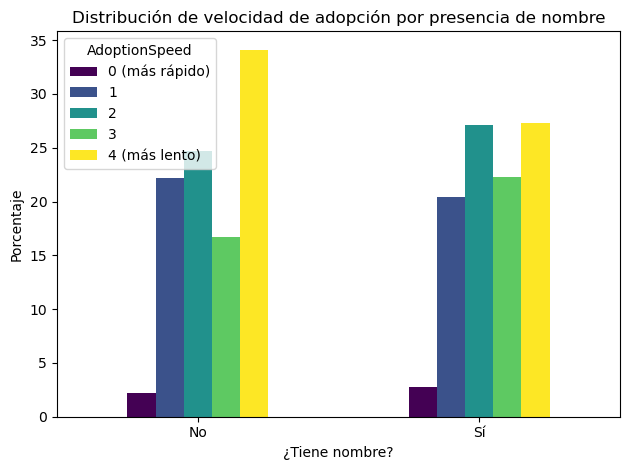

In [ ]:

#Columna que indique si el animal tiene nombre o no
dataset['Tiene_Nombre'] = dataset['Nombres_limpios'] != 'Sin Nombre'
print(dataset['Tiene_Nombre'].value_counts() )
adoption_counts = dataset.groupby(['Tiene_Nombre', 'AdoptionSpeed']).size().unstack(fill_value=0)
# Calcular porcentajes por fila (para cada grupo de Tiene_Nombre)
adoption_percentages = adoption_counts.div(adoption_counts.sum(axis=1), axis=0) * 100
print("\nPorcentaje de animales por velocidad de adopción:")
print(adoption_percentages)

adoption_percentages.plot(kind='bar', cmap= 'viridis')
plt.title('Distribución de velocidad de adopción por presencia de nombre')
plt.xlabel('¿Tiene nombre?')
plt.ylabel('Porcentaje')
plt.xticks(ticks=[0, 1], labels=['No', 'Sí'], rotation=0)
plt.legend(title='AdoptionSpeed', labels=['0 (más rápido)', '1', '2', '3', '4 (más lento)'])
plt.tight_layout()


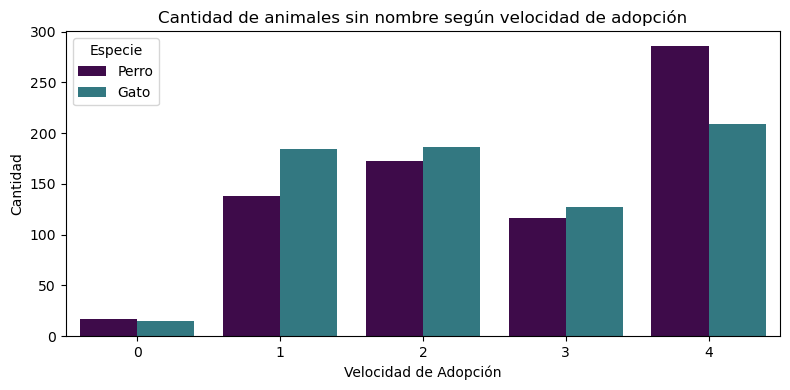

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

type_labels = {1: 'Perro', 2: 'Gato'}
data = dataset[dataset['Nombres_limpios'] == 'Sin Nombre'] \
    .groupby(['Type', 'AdoptionSpeed']) \
    .size() \
    .reset_index(name='count')

data['Type'] = data['Type'].map(type_labels)

# Crear gráfico de barras agrupadas
plt.figure(figsize=(8,4))
sns.barplot(data=data, x='AdoptionSpeed', y='count', hue='Type', palette=['#440154', '#26828e'])

plt.title('Cantidad de animales sin nombre según velocidad de adopción')
plt.xlabel('Velocidad de Adopción')
plt.ylabel('Cantidad')
plt.legend(title='Especie')
plt.tight_layout()
plt.show()



Distribución de la edad de las mascotas por especie.

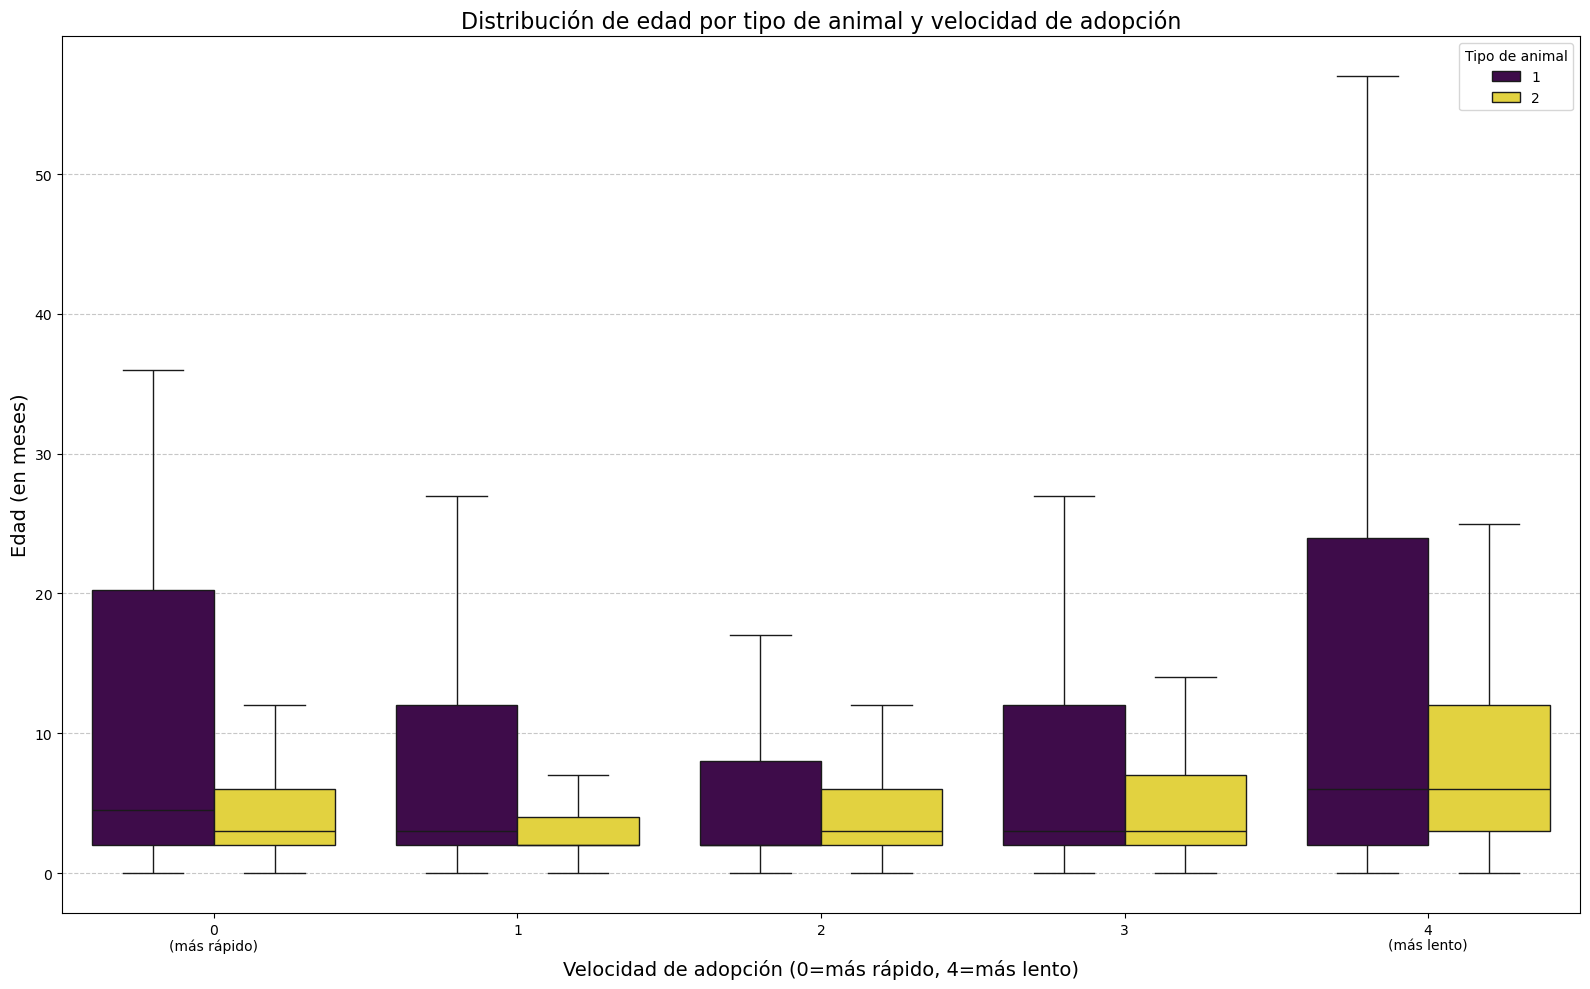

Estadísticas de edad por tipo de animal y velocidad de adopción:
                    count  mean  median   std
Type AdoptionSpeed                           
1    0                170  15.8     4.5  22.4
     1               1435  11.9     3.0  19.9
     2               2164  11.0     2.0  20.4
     3               1949  11.8     3.0  20.3
     4               2414  15.9     6.0  23.5
2    0                240   6.6     3.0  12.3
     1               1655   5.5     2.0  10.1
     2               1873   6.3     3.0  10.8
     3               1310   7.8     3.0  15.7
     4               1783  10.7     6.0  13.9

Análisis para 2:
ANOVA: F=42.34, p=0.0000
Hay diferencias significativas en la edad entre las diferentes velocidades de adopción

Análisis para 1:
ANOVA: F=19.18, p=0.0000
Hay diferencias significativas en la edad entre las diferentes velocidades de adopción


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Crear una figura con un tamaño adecuado
plt.figure(figsize=(16, 10))

# Usar seaborn para crear un boxplot más completo y personalizable
ax = sns.boxplot(x='AdoptionSpeed', y='Age', hue='Type', data=dataset, 
                 palette='viridis', showfliers=False)

# Añadir títulos y etiquetas
plt.title('Distribución de edad por tipo de animal y velocidad de adopción', fontsize=16)
plt.xlabel('Velocidad de adopción (0=más rápido, 4=más lento)', fontsize=14)
plt.ylabel('Edad (en meses)', fontsize=14)
plt.xticks(ticks=range(5), labels=['0\n(más rápido)', '1', '2', '3', '4\n(más lento)'])
plt.legend(title='Tipo de animal')

# Opcional: Añadir una cuadrícula para facilitar la lectura
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

# Adicionalmente, puedes calcular estadísticas descriptivas
stats = dataset.groupby(['Type', 'AdoptionSpeed'])['Age'].agg(['count', 'mean', 'median', 'std']).round(1)
print("Estadísticas de edad por tipo de animal y velocidad de adopción:")
print(stats)

# Realizar un análisis estadístico para comprobar si hay diferencias significativas
# Por ejemplo, un ANOVA de dos vías
from scipy import stats as stats_scipy

# Para cada tipo de animal, verificar si hay diferencias de edad entre velocidades de adopción
for animal_type in dataset['Type'].unique():
    print(f"\nAnálisis para {animal_type}:")
    groups = [dataset[(dataset['Type'] == animal_type) & (dataset['AdoptionSpeed'] == i)]['Age'] 
              for i in range(5)]
    # Eliminar grupos vacíos
    groups = [g for g in groups if len(g) > 0]
    
    if len(groups) > 1:  # Necesitamos al menos 2 grupos para comparar
        f_stat, p_val = stats_scipy.f_oneway(*groups)
        print(f"ANOVA: F={f_stat:.2f}, p={p_val:.4f}")
        if p_val < 0.05:
            print(f"Hay diferencias significativas en la edad entre las diferentes velocidades de adopción")
        else:
            print(f"No hay diferencias significativas en la edad entre las diferentes velocidades de adopción")

Análisis de la columna de Rescuer_id.

In [ ]:
# Cantidad de registros por cada rescatista
dataset.RescuerID.value_counts()
print (f'Son ',    dataset['RescuerID'].nunique(), 'rescatistas los que publicaron anuncios según el dataset. Y los que mas anuncios publicaron pueden verse en el siguiente listado:')
dataset.RescuerID.value_counts()

Son  5595 rescatistas los que publicaron anuncios según el dataset. Y los que mas anuncios publicaron pueden verse en el siguiente listado:


RescuerID
fa90fa5b1ee11c86938398b60abc32cb    459
aa66486163b6cbc25ea62a34b11c9b91    315
c00756f2bdd8fa88fc9f07a8309f7d5d    231
b53c34474d9e24574bcec6a3d3306a0d    228
ee2747ce26468ec44c7194e7d1d9dad9    156
                                   ... 
89bc6d71d57ad5d7e952ed76559345c5      1
8cfafc812c500eee7c112911ef668ce9      1
8512e22c06a01cdc76481ff0a6e88b67      1
48de9ff092328d54b2b371bc72b07b03      1
79309f4027f2fedb4349a298c69fe56f      1
Name: count, Length: 5595, dtype: int64

          Quantity
count  5595.000000
mean      4.223414
std      13.387855
min       1.000000
25%       1.000000
50%       2.000000
75%       4.000000
max     531.000000


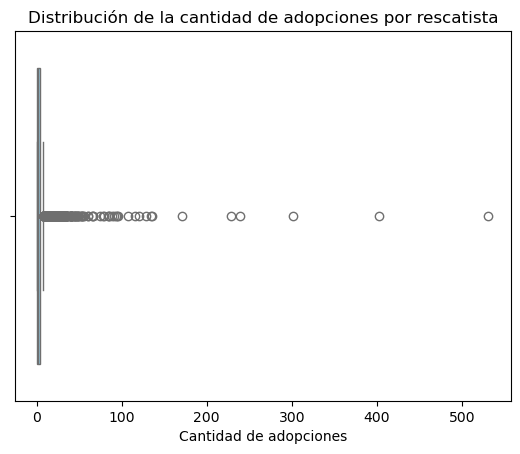

El cuartil 95 de adoptados_por_rescatista es 13.0
El cuartil 98 de adoptados_por_rescatista es 25.0
El cuartil 99 de adoptados_por_rescatista es 39.0


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear un DataFrame con la cantidad de adopciones por rescatista
adoptados_por_rescatista = dataset.groupby('RescuerID')['Quantity'].sum().reset_index().sort_values(by='Quantity', ascending=False)
print(adoptados_por_rescatista.describe())

# Crear el boxplot
plt.figure()
sns.boxplot(data=adoptados_por_rescatista, x='Quantity', color='skyblue', orient='h')
plt.title('Distribución de la cantidad de adopciones por rescatista')
plt.xlabel('Cantidad de adopciones')
plt.show()

print(f"El cuartil 95 de adoptados_por_rescatista es {adoptados_por_rescatista['Quantity'].quantile(0.95)}")  # 95 percentil.quantile(0.95)) # 95 percentil
print(f"El cuartil 98 de adoptados_por_rescatista es {adoptados_por_rescatista['Quantity'].quantile(0.98)}") 
print(f"El cuartil 99 de adoptados_por_rescatista es {adoptados_por_rescatista['Quantity'].quantile(0.99)}") 


In [ ]:
# Agrupar los datos por 'RescuerID' y contar la cantidad de adopciones realizadas por cada rescatista
adopciones_por_rescatista = dataset.groupby('RescuerID')['Quantity'].count().reset_index().sort_values(by='Quantity', ascending=False)

# Calcular y mostrar los percentiles deseados para la cantidad de adopciones por rescatista
percentiles = [1, 2, 5, 10] + list(range(80, 101, 1))  # Lista de percentiles a calcular
for p in percentiles:
    valor = adopciones_por_rescatista['Quantity'].quantile(p / 100)  # Calcular el percentil
    print(f"Percentil {p}: {valor}")  # Mostrar el valor del percentil

# Función para asignar un estrato basado en los percentiles
def asignar_estrato(valor):
    if valor <= adopciones_por_rescatista['Quantity'].quantile(0.82):  # Si está en el percentil 82 o menos
        return 1  # Estrato 1
    elif valor <= adopciones_por_rescatista['Quantity'].quantile(0.92):  # Si está entre el percentil 83 y 92
        return 2  # Estrato 2
    elif valor <= adopciones_por_rescatista['Quantity'].quantile(0.98):  # Si está entre el percentil 93 y 98
        return 3  # Estrato 3
    else:  # Si está por encima del percentil 98
        return 4  # Estrato 4

# Asignar los estratos a cada rescatista en función de la cantidad de adopciones
adopciones_por_rescatista['Estrato'] = adopciones_por_rescatista['Quantity'].apply(asignar_estrato)

# Mostrar los primeros registros del DataFrame para verificar los resultados
print(adopciones_por_rescatista.head())

Percentil 1: 1.0
Percentil 2: 1.0
Percentil 5: 1.0
Percentil 10: 1.0
Percentil 80: 2.0
Percentil 81: 2.0
Percentil 82: 2.0
Percentil 83: 3.0
Percentil 84: 3.0
Percentil 85: 3.0
Percentil 86: 3.0
Percentil 87: 3.0
Percentil 88: 4.0
Percentil 89: 4.0
Percentil 90: 4.0
Percentil 91: 5.0
Percentil 92: 5.0
Percentil 93: 6.0
Percentil 94: 6.0
Percentil 95: 7.0
Percentil 96: 9.0
Percentil 97: 11.0
Percentil 98: 15.0
Percentil 99: 25.0600000000004
Percentil 100: 459.0
                             RescuerID  Quantity  Estrato
5485  fa90fa5b1ee11c86938398b60abc32cb       459        4
3768  aa66486163b6cbc25ea62a34b11c9b91       315        4
4228  c00756f2bdd8fa88fc9f07a8309f7d5d       231        4
3996  b53c34474d9e24574bcec6a3d3306a0d       228        4
5204  ee2747ce26468ec44c7194e7d1d9dad9       156        4


In [ ]:
#mapeo de cantidad de rescatados por RescuerID
dataset['categoria_rescatista'] = dataset['RescuerID'].map(adopciones_por_rescatista.set_index('RescuerID')['Estrato'])
dataset["categoria_rescatista"].value_counts()

categoria_rescatista
1    5399
4    4865
3    2509
2    2220
Name: count, dtype: int64

Se asignó una categoría o "estrato" a cada rescatista en el dataset, basado en la cantidad de adopciones que han gestionado. Se visualizan la cantidad de rescatistas por categoria.